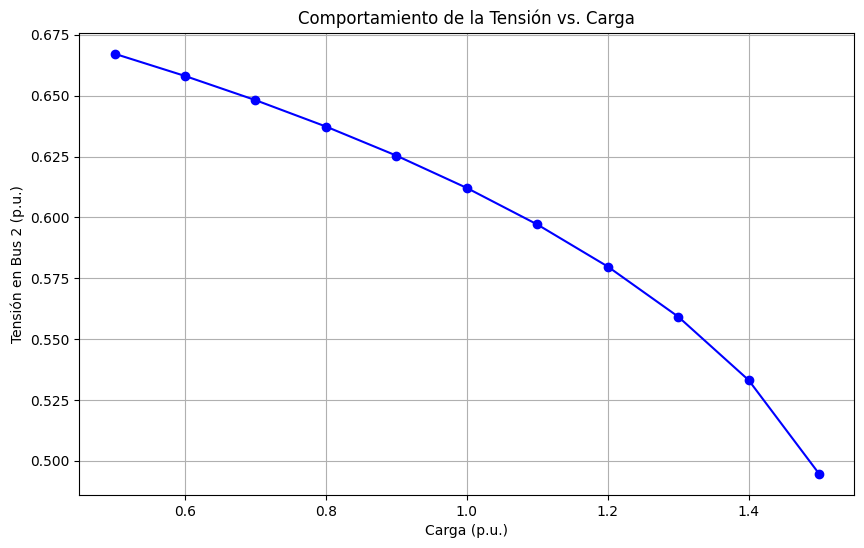

LoadflowNotConverged: Power Flow nr did not converge after 10 iterations!

In [10]:
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np

# Crear la red de ejemplo
net = pp.create_empty_network()

# Crear barras
bus1 = pp.create_bus(net, vn_kv=110, name="Bus 1")
bus2 = pp.create_bus(net, vn_kv=220, name="Bus 2")

# Crear una línea de transmisión
pp.create_line(net, from_bus=bus1, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV")

# Crear un transformador
pp.create_transformer(net, hv_bus=bus1, lv_bus=bus2, std_type="100 MVA 220/110 kV")

# Crear una barra slack
pp.create_ext_grid(net, bus=bus1, vm_pu=1.02)

# Definir la carga nominal
p_nominal = 1080  # MW
q_nominal = 523.0679   # MVAr

# Rango de carga ±50%
p_values = np.linspace(0.5 * p_nominal, 1.5 * p_nominal, 11)
voltages = []

# Simular para cada valor de carga
for p in p_values:
    pp.create_load(net, bus=bus2, p_mw=p, q_mvar=q_nominal)
    pp.runpp(net)
    voltages.append(net.res_bus.vm_pu[bus2])
    net.load.drop(net.load.index, inplace=True)  # Resetear las cargas para la próxima simulación

# Graficar los resultados
plt.figure(figsize=(10,6))
plt.plot(p_values / p_nominal, voltages, 'bo-')
plt.title('Comportamiento de la Tensión vs. Carga')
plt.xlabel('Carga (p.u.)')
plt.ylabel('Tensión en Bus 2 (p.u.)')
plt.grid()
plt.show()

# Limites de tensión de la normativa
lower_limit = 0.95
upper_limit = 1.05

compensations = []
voltages_with_compensation = []

# Simular para cada valor de carga y calcular la compensación necesaria
for p in p_values:
    pp.create_load(net, bus=bus2, p_mw=p, q_mvar=q_nominal)
    pp.runpp(net)
    initial_voltage = net.res_bus.vm_pu[bus2]
    
    # Añadir compensación shunt si la tensión está fuera de los límites
    q_shunt = 0
    while initial_voltage < lower_limit or initial_voltage > upper_limit:
        # Añadir compensación shunt de manera iterativa
        q_shunt += 0.5  # Añadir un capacitor de 0.5 MVAr
        pp.create_shunt(net, bus=bus2, q_mvar=q_shunt)
        pp.runpp(net)
        initial_voltage = net.res_bus.vm_pu[bus2]
    
    compensations.append(q_shunt)
    voltages_with_compensation.append(initial_voltage)
    net.shunt.drop(net.shunt.index, inplace=True)  # Resetear los shunts para la próxima simulación
    net.load.drop(net.load.index, inplace=True)  # Resetear las cargas para la próxima simulación

# Graficar los resultados
plt.figure(figsize=(10,6))
plt.plot(p_values / p_nominal, voltages, 'bo-', label='Sin Compensación')
plt.plot(p_values / p_nominal, voltages_with_compensation, 'ro-', label='Con Compensación')
plt.title('Comportamiento de la Tensión vs. Carga con y sin Compensación')
plt.xlabel('Carga (p.u.)')
plt.ylabel('Tensión en Bus 2 (p.u.)')
plt.legend()
plt.grid()
plt.show()

# Pérdidas en la línea
losses_without_compensation = []
losses_with_compensation = []

# Simular para cada valor de carga y calcular las pérdidas sin compensación
for p in p_values:
    pp.create_load(net, bus=bus2, p_mw=p, q_mvar=q_nominal)
    pp.runpp(net)
    losses_without_compensation.append(net.res_line.pl_mw.sum())
    net.load.drop(net.load.index, inplace=True)  # Resetear las cargas para la próxima simulación

# Simular para cada valor de carga y calcular las pérdidas con compensación
for p, q_shunt in zip(p_values, compensations):
    pp.create_load(net, bus=bus2, p_mw=p, q_mvar=q_nominal)
    pp.create_shunt(net, bus=bus2, q_mvar=q_shunt)
    pp.runpp(net)
    losses_with_compensation.append(net.res_line.pl_mw.sum())
    net.shunt.drop(net.shunt.index, inplace=True)  # Resetear los shunts para la próxima simulación
    net.load.drop(net.load.index, inplace=True)  # Resetear las cargas para la próxima simulación

# Graficar los resultados
plt.figure(figsize=(10,6))
plt.plot(p_values / p_nominal, losses_without_compensation, 'bo-', label='Sin Compensación')
plt.plot(p_values / p_nominal, losses_with_compensation, 'ro-', label='Con Compensación')
plt.title('Pérdidas en la Línea vs. Carga')
plt.xlabel('Carga (p.u.)')
plt.ylabel('Pérdidas en la Línea (MW)')
plt.legend()
plt.grid()
plt.show()



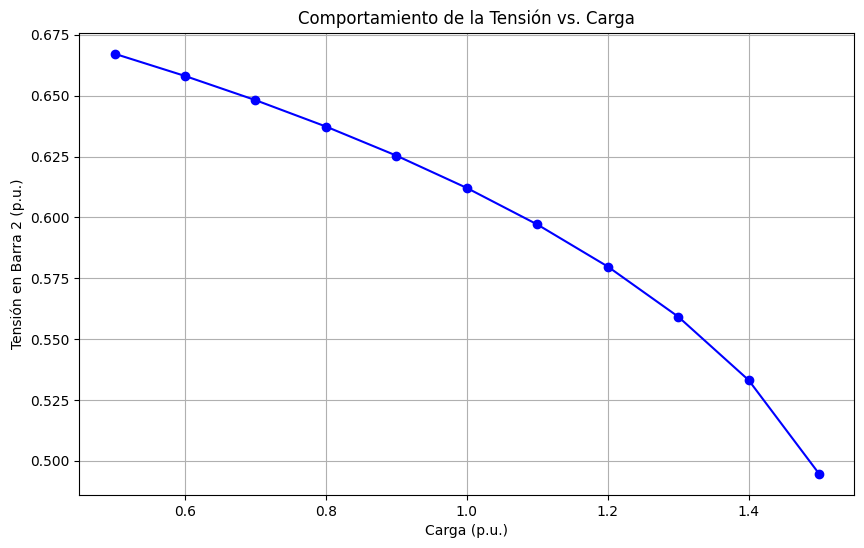

In [24]:
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np

# Red de referencia
net = pp.create_empty_network()

# Barras
bus1 = pp.create_bus(net, vn_kv=110, name="Bus 1")
bus2 = pp.create_bus(net, vn_kv=220, name="Bus 2")

# Lineas de transmisión
pp.create_line(net, from_bus=bus1, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV")

# Transformador
pp.create_transformer(net, hv_bus=bus1, lv_bus=bus2, std_type="100 MVA 220/110 kV")

# Barra slack
pp.create_ext_grid(net, bus=bus1, vm_pu=1.02)

# Carga nominal
p_nominal = 1080  # MW
q_nominal = 523.0679   # MVAr

# Rango de carga ±50%
p_values = np.linspace(0.5 * p_nominal, 1.5 * p_nominal, 11)
voltages = []

# Simular para cada valor de carga
for p in p_values:
    pp.create_load(net, bus=bus2, p_mw=p, q_mvar=q_nominal)
    pp.runpp(net)
    voltages.append(net.res_bus.vm_pu[bus2])
    net.load.drop(net.load.index, inplace=True)  # Resetear las cargas para la próxima simulación

# Graficar los resultados
plt.figure(figsize=(10,6))
plt.plot(p_values / p_nominal, voltages, 'bo-')
plt.title('Comportamiento de la Tensión vs. Carga')
plt.xlabel('Carga (p.u.)')
plt.ylabel('Tensión en Barra 2 (p.u.)')
plt.grid()
plt.show()